Copyright 2023 ICUBE Laboratory, University of Strasbourg

License: Apache License, Version 2.0

Author: Thibault Poignonec (thibault.poignonec@gmail.com)

Created on Tue Oct 2023

# Generate some data

In [8]:
import numpy as np
from scipy.linalg import block_diag
import os
from copy import deepcopy
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

# 1DOF backlash models (2 to 4 parameters per element)
from backlash_simulation_examples.models.model_1dof_backlash import eval_1DOF_backlash
# 3 dof endoscopic tool
from backlash_simulation_examples.models.model_endoscope_3D import EndoscopicToolModel

## Define endoscope specification + time

In [9]:

# Endoscope kinematics
endoscope_kin_model = EndoscopicToolModel(L=0.018, d=0.02)
diameter_endoscope_body = 0.0035

# Indexe of individual backlash elements x_i
x_i_indexes = [range(0,5), range(5, 10), range(10, 15)]

# workspace
c_min_values = np.array([0.03, -np.pi/2, -np.pi*3/4])
c_max_values = np.array([0.07, np.pi/2, np.pi/2])
q_min_values = c_min_values * np.array([1,diameter_endoscope_body,1])
q_max_values = c_max_values * np.array([1,diameter_endoscope_body,1])

# time
t_max = 180.0
dt = 0.02
t = np.arange(0.0, t_max, dt)

## Define simulation utils

In [10]:

def evaluate_all_backlash_elements(x_k_1, q_k, q_k_1, singularity_management = False, exitation_management = False) :
    # Prepare functions
    f_trans, F_trans, map_trans_xi_to_c, observable_trans = eval_1DOF_backlash(x_k_1[x_i_indexes[0]], q_k[0], q_k_1[0], dof=4)
    f_bend, F_bend, map_bend_xi_to_c, observable_bend = eval_1DOF_backlash(x_k_1[x_i_indexes[1]], q_k[1], q_k_1[1], dof=4)
    f_rot, F_rot, map_rot_xi_to_c, observable_rot = eval_1DOF_backlash(x_k_1[x_i_indexes[2]], q_k[2], q_k_1[2], dof=4)

    # Aggregate transition model
    f = lambda x_k_1, q_k : np.concatenate([
            f_trans( x_k_1[x_i_indexes[0]], q_k[0]),
            f_bend(  x_k_1[x_i_indexes[1]], q_k[1]),
            f_rot(   x_k_1[x_i_indexes[2]], q_k[2])
    ])
    F = block_diag(F_trans, F_bend, F_rot)

    # Aggregate mapping  "x to c"
    map_x_to_c = np.block([
        [map_trans_xi_to_c,                    np.zeros(map_bend_xi_to_c.shape),    np.zeros(map_rot_xi_to_c.shape)],
        [np.zeros(map_trans_xi_to_c.shape),    map_bend_xi_to_c,                    np.zeros(map_rot_xi_to_c.shape)],
        [np.zeros(map_trans_xi_to_c.shape),    np.zeros(map_bend_xi_to_c.shape),    map_rot_xi_to_c]
    ])
    # Aggregate observability
    observability = np.concatenate([observable_trans, observable_bend, observable_rot])

    return f, F, map_x_to_c, observability

def get_x_i(x_k, i) : # Attention, x_1 -> i = 1 (pas de 0 !!!)
    if x_k.shape[0] > 15 :
        # Table
        return x_k[:,x_i_indexes[i-1]]
    else :
        # Vector
        return x_k[x_i_indexes[i-1],0]

def get_c_i(x_k, i) : # Attention, x_1 -> i = 1 (pas de 0 !!!)
    if x_k.shape[0] > 15 :
        # Table
        return get_x_i(x_k, i)[:,0]
    else :
        # Vector
        return get_x_i(x_k, i)[0]


def generate_dummy_state_data(t, q_data) :
    x_data = np.zeros((t.shape[0], 15))
    x_data[0,:] = np.concatenate([
            np.array([0.001]), theta_translation,
            np.array([0.1]), theta_bending,
            np.array([0.1]), theta_rotation]
    )

    for k in range(1,t.shape[0]):
        q_k = np.copy(q_data[k,:])
        q_k_1 = np.copy(q_data[k-1,:])
        # Update functions
        f, F, map_x_to_c, observable = evaluate_all_backlash_elements(
                                            x_k_1   = x_data[k-1,:],
                                            q_k     = q_k,
                                            q_k_1   = q_k_1,
                                            singularity_management = False,
                                            exitation_management = False
        )
        # h = lambda x_k : endoscope_kin_model.f_kinematics(np.dot(map_x_to_c, x_k))
        # H = lambda x_k : endoscope_kin_model.f_jacobian(np.dot(map_x_to_c, x_k)).dot(map_x_to_c)

        # Update state
        x_data[k,:] = f(x_k_1 = x_data[k-1,:], q_k = q_k)

    x_data[0,:] = x_data[1,:].copy()

    return x_data

## Generate q, c, and p data

In [11]:
# Generate q data
q_1 = 2*np.sin(np.pi/17*t) + 4*np.cos(np.pi/2*t)*np.exp(-t/10) + 3*np.sin(np.pi/4*t) - 3*np.sin(np.pi/6*t)
q_2 = np.sin(np.pi/5*t) - 8*np.sin(np.pi/2*t)*np.exp(-t/5) + 5*np.cos(np.pi/4*t) - 2*np.sin(np.pi/10*t)
q_3 = 2*np.sin(np.pi/9*t) - 7*np.sin(np.pi/10*t)*np.exp(-t/5) + 5*np.cos(np.pi/8*t) - 2*np.sin(np.pi/2*t)

q_data = np.zeros((q_1.shape[0], 3))
for q_i, i in zip([q_1, q_2, q_3], [0,1,2]) :
    q_data[:,i] = q_i.copy()
    q_data[:,i] = q_data[:,i] - np.min(q_data[:,i])
    q_data[:,i] = q_data[:,i]/np.max(q_data[:,i]) * (q_max_values[i] - q_min_values[i]) + q_min_values[i]

# "Real" model parameters + generate c data
m_nominal_translation = 1
m_nominal_bending = 1/diameter_endoscope_body
m_nominal_rotation = 1

theta_translation = np.array([0.005, 0.007, m_nominal_translation*1.05, m_nominal_translation*1.05])
theta_bending = np.array([(np.pi/20 - np.pi/12)/m_nominal_bending, (np.pi/20 + np.pi/12)/m_nominal_bending, m_nominal_bending*1.05, m_nominal_bending*0.95])
theta_rotation = np.array([(-np.pi/10)/m_nominal_rotation, (np.pi/6)/m_nominal_rotation, m_nominal_rotation*0.95, m_nominal_rotation*1.05])

# Simulate state traj.
x_data = generate_dummy_state_data(t, q_data)

# Extract config vars
c_data = np.zeros(q_data.shape)
c_data[:,0] = get_c_i(x_data, i = 1).copy()
c_data[:,1] = get_c_i(x_data, i = 2).copy()
c_data[:,2] = get_c_i(x_data, i = 3).copy()

# Cartesian poses
p_data = np.zeros((t.shape[0], 3))
for idx in range(c_data.shape[0]) :
    c_star = c_data[idx, :].copy()
    p_data[idx,:] = endoscope_kin_model.f_kinematics(c_star).reshape((-1,))

std_noise_z = 0#0.0005
noise_z_data = np.random.normal(0,std_noise_z, p_data.shape[0]*p_data.shape[1]).reshape(p_data.shape)
z_data = p_data + noise_z_data

# Plotting

## Plotting utils

In [12]:
# Plotting utils
def get_c_from_x_k(x_k) :
    return np.array([get_c_i(x_k, 1), get_c_i(x_k, 2), get_c_i(x_k, 3)])

def plot_hysteresis(ax, q_normal_units, c_normal_units, label, color, alpha=0.5) :    
    return ax.plot(q_normal_units, c_normal_units, color=color, label=label, alpha=alpha)

def plot_normalized_hysteresis(ax, q_normal_units, c_normal_units, label, color, alpha=0.5) :
    q_normalized = q_normal_units.copy()    
    q_normalized = q_normalized - np.min(q_normalized)
    q_normalized = q_normalized/np.max(q_normalized) * 2  - 1    
    c_normalized = c_normal_units.copy()    
    c_normalized = c_normalized - np.min(c_normalized)
    c_normalized = c_normalized/np.max(c_normalized) * 2  - 1    
    return plot_hysteresis(ax, q_normalized, c_normalized, label, color, alpha)

## Plot q and c

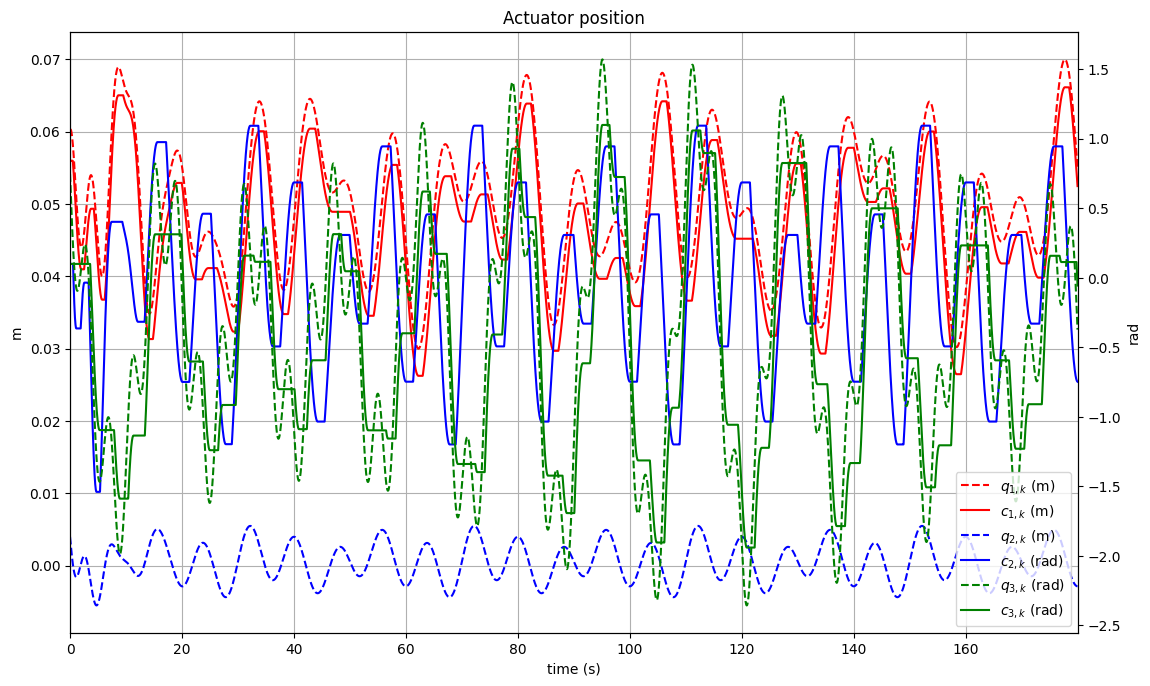

In [13]:
# Plot q_data    
fig, ax_meters = plt.subplots(
            1,1, 
            figsize=(plt.rcParams["figure.figsize"][0], 0.6*plt.rcParams["figure.figsize"][0])
            )
ax_meters.set_title("Actuator position")
lns = []
# Translation
lns += ax_meters.plot( t, q_data[:,0], '--r', label = r'$q_{1,k}$ (m)')
lns += ax_meters.plot( t, c_data[:,0], 'r',   label = r'$c_{1,k}$ (m)')
ax_meters.set_xlabel('time (s)') 
ax_meters.set_ylabel('m')#, color = 'r') 
#ax_meters.tick_params(axis ='y', labelcolor = 'red') 
ax_radians = ax_meters.twinx() 
# Bending
lns += ax_meters.plot(t,  q_data[:,1], '--b', label = r'$q_{2,k}$ (m)')
lns += ax_radians.plot(t, c_data[:,1], 'b',   label = r'$c_{2,k}$ (rad)')
# Rotation
lns += ax_radians.plot(t,  q_data[:,2], '--g', label = r'$q_{3,k}$ (rad)')
lns += ax_radians.plot(t,  c_data[:,2], 'g',   label = r'$c_{3,k}$ (rad)')
ax_radians.set_ylabel('rad') 
plt.legend(lns, [l.get_label() for l in lns], frameon=True)
ax_meters.set_xlim(0,t[-1])
ax_meters.grid()
plt.show()


## Misc. plots

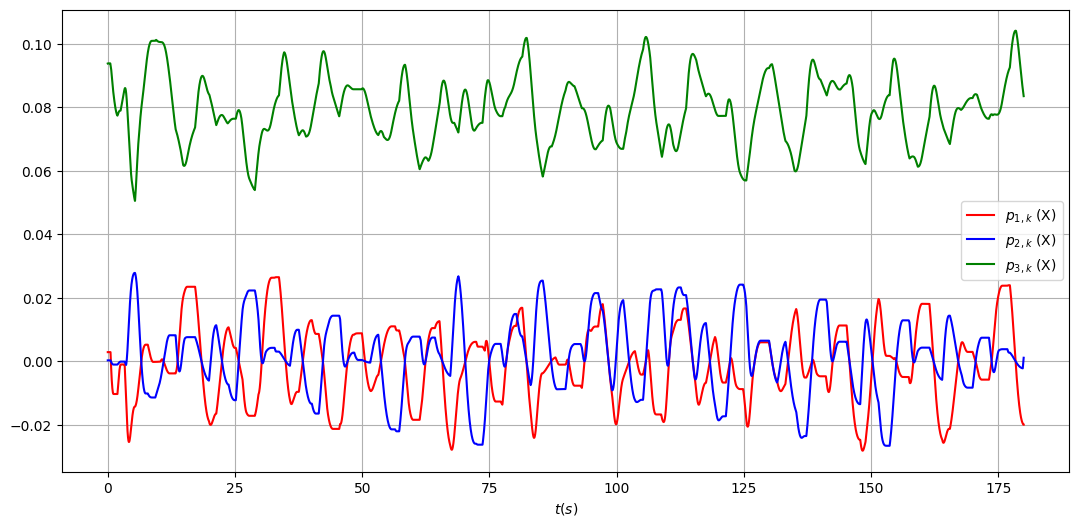

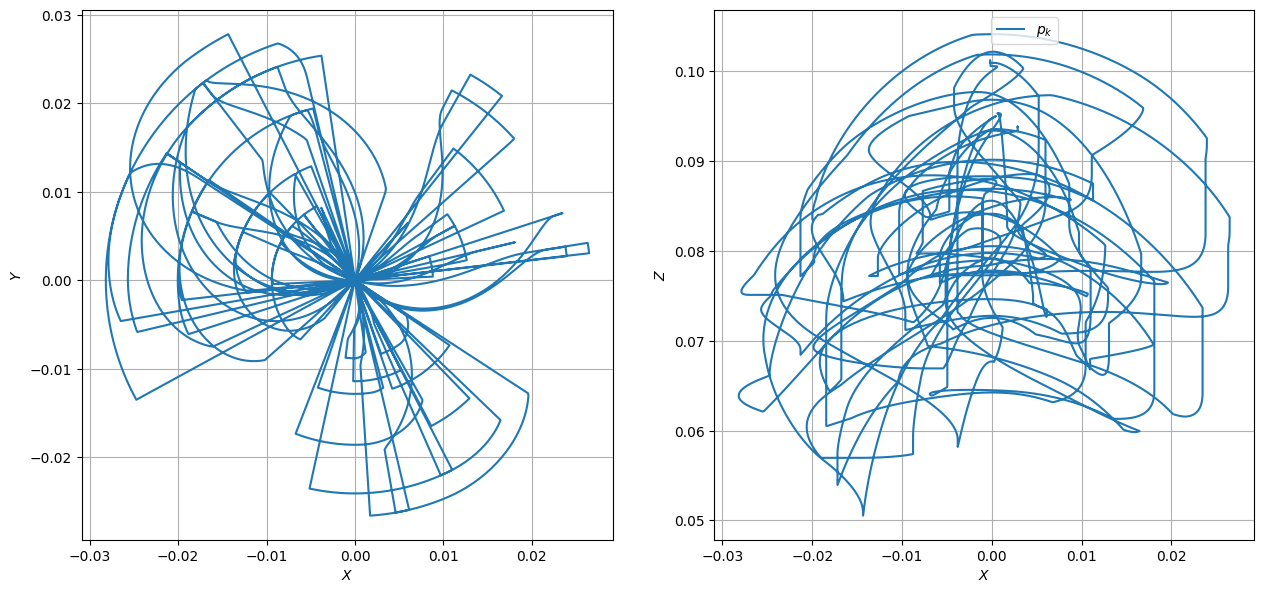

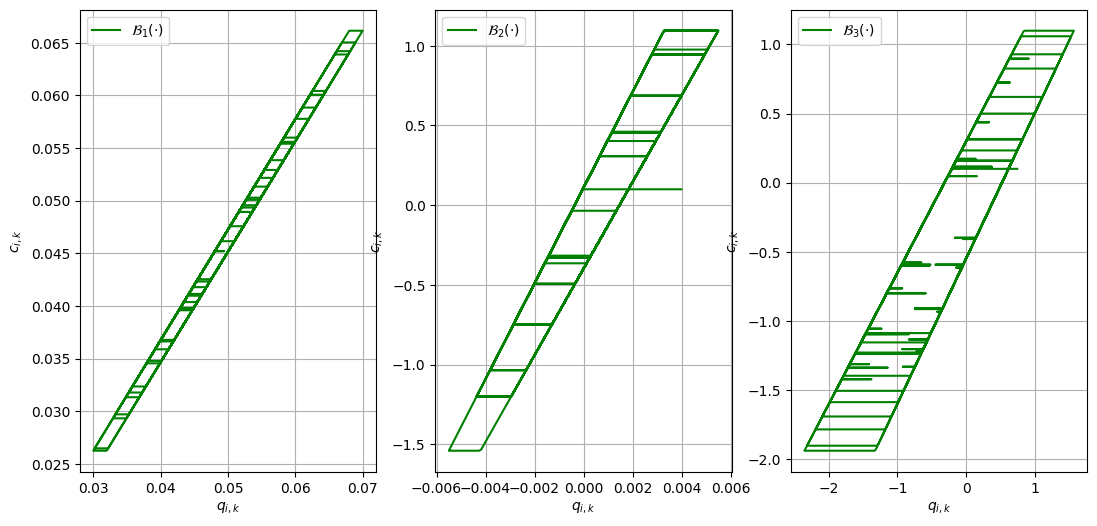

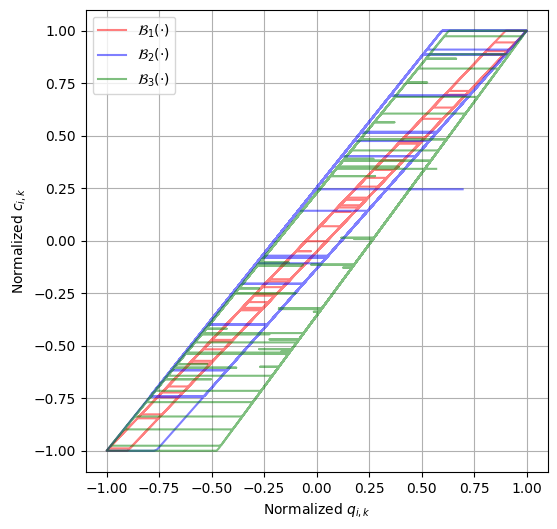

In [14]:
# Plot position p  and observation z
fig, ax1 = plt.subplots(1,1)
ax1.plot(t, p_data[:,0], label = r'$p_{1,k}$ (X)', color = 'red')
ax1.plot(t, p_data[:,1], label = r'$p_{2,k}$ (X)', color = 'blue')
ax1.plot(t, p_data[:,2], label = r'$p_{3,k}$ (X)', color = 'green')
ax1.set_xlabel(r'$t(s)$')
ax1.grid()
ax1.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(p_data[:,0], p_data[:,1], label = r'$p_{k}$ (XY)')
ax1.set_xlabel(r'$X$')
ax1.set_ylabel(r'$Y$')
ax1.grid()
ax1.set_aspect('equal')

ax2.plot(p_data[:,0], p_data[:,2], label = r'$p_{k}$')
ax2.set_xlabel(r'$X$')
ax2.set_ylabel(r'$Z$')
ax2.grid()
ax2.set_aspect('equal')
ax2.legend(frameon = True, loc = "upper left", bbox_to_anchor=(0.5,1))

plt.tight_layout()
plt.show()

#%%  Plot hysteresis cycles
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.plot(q_data[:,0], c_data[:,0], label = r'$\mathcal{B}_1(\cdot)$', color = 'green')
ax2.plot(q_data[:,1], c_data[:,1], label = r'$\mathcal{B}_2(\cdot)$', color = 'green')
ax3.plot(q_data[:,2], c_data[:,2], label = r'$\mathcal{B}_3(\cdot)$', color = 'green')
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel(r'$q_{i,k}$')
    ax.set_ylabel(r'$c_{i,k}$')
    ax.grid()
    ax.legend()
plt.show()

# Plot normalized hystereses
fig, ax = plt.subplots(1,1)
plot_normalized_hysteresis(ax, q_data[1:,0], c_data[1:,0], label = r'$\mathcal{B}_1(\cdot)$', color = 'red')
plot_normalized_hysteresis(ax, q_data[1:,1], c_data[1:,1], label = r'$\mathcal{B}_2(\cdot)$', color = 'blue')
plot_normalized_hysteresis(ax, q_data[1:,2], c_data[1:,2], label = r'$\mathcal{B}_3(\cdot)$', color = 'green')
ax.set_xlabel(r'Normalized $q_{i,k}$')
ax.set_ylabel(r'Normalized $c_{i,k}$')
ax.grid()
ax.set_aspect('equal')
ax.legend()
plt.show()